# 3.5 뉴스 기사 분류- 다중 분류 문제

이 절에서 로이터 뉴스를 46개의 상호 배타적인 토픽으로 분류하는 신경망을 만들어 보겠습니다. 클래스가 많기 때문에 이 문제는 다중 분류(multiclass classification)의 예입니다. 좀 더 정확히 말하면 단일 레이블 다중 분류(single-label, multiclass classification) 문제입니다.

### 3.5.1 로이터 데이터셋
#### 코드 3-12 로이터 데이터셋 로드하기

In [4]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

In [5]:
len(train_data)

8982

In [6]:
len(test_data)

2246

In [7]:
train_data[10]

[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

#### 코드 3-13 로이터 데이터셋을 텍스트로 디코딩하기

In [8]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
train_labels[10]

3

### 3.5.2 데이터 준비
#### 코드 3-14 데이터 인코딩하기

In [9]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

레이블을 벡터로 바꾸는 방법은 두 가지 입니다. 레이블의 리스트를 정수 텐서로 변환하는 것과 원-핫 인코딩을 사용하는 것입니다. 원-핫 인코딩이 범주형 데이터에 널리 사용되기 때문에 범주형 인코딩(categorical encoding)이라고도 부릅니다.

In [10]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

MNIST 예제에서 이미 보았듯이 케라스에는 이를 위한 내장 함수가 있습니다.

In [11]:
# from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

### 3.5.3 모델 구성
이전 예제에서 16차원을 가진 중간층을 사용했지만 16차원 공간은 64개의 클래스를 구분하기에 너무 제약이 많을 것 같습니다. 이렇게 규모가 작은 층은 유용한 정보를 완전히 잃게 되는 정보의 병목지점처럼 동작할 수 있습니다.
이런 이유로 좀 더 규모가 큰 층을 사용하겠습니다.

64개의 유닛을 사용해 보죠.
#### 코드 3-15 모델 정의하기

In [12]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

이런 문제에 사용할 최선의 손실 함수는 categorical_crossentropy입니다. 이 함수는 두 확률 분포 사이의 거리를 측정합니다. 여기에서는 네트워크가 출력한 확률 부포와 진짜 레이블의 분포 사이의 거리입니다. 두 분포 사이의 거리를 최소화하면 진짜 레이블에 가능한 가까운 출력을 내도록 모델을 훈련하게 됩니다.

#### 코드 3-16 모델 컴파일하기

In [13]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 3.5.4 훈련 검증
#### 코드 3-17 검증 세트 준비하기

In [14]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

#### 코드 3-18 모델 훈련하기

In [15]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.3624 - loss: 3.1349 - val_accuracy: 0.6050 - val_loss: 1.8178
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6396 - loss: 1.6760 - val_accuracy: 0.6890 - val_loss: 1.4039
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7352 - loss: 1.2430 - val_accuracy: 0.7350 - val_loss: 1.2219
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7818 - loss: 1.0289 - val_accuracy: 0.7740 - val_loss: 1.1072
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8191 - loss: 0.8433 - val_accuracy: 0.7880 - val_loss: 1.0166
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8451 - loss: 0.7111 - val_accuracy: 0.7970 - val_loss: 0.9612
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8828 - loss: 0.5870 - val_accuracy: 0.8110 - val_loss: 0.9132
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8952 - loss: 0.5027 - val_accuracy: 0.8170 - v

#### 코드 3-19 훈련과 검증 손실 그리기

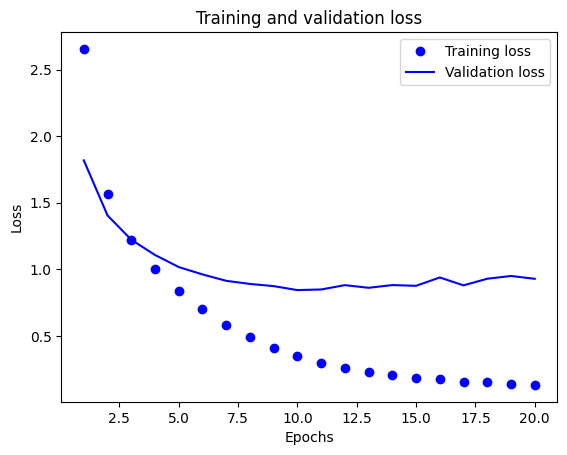

In [16]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### 코드 3-20 훈련과 검증 정확도 그리기

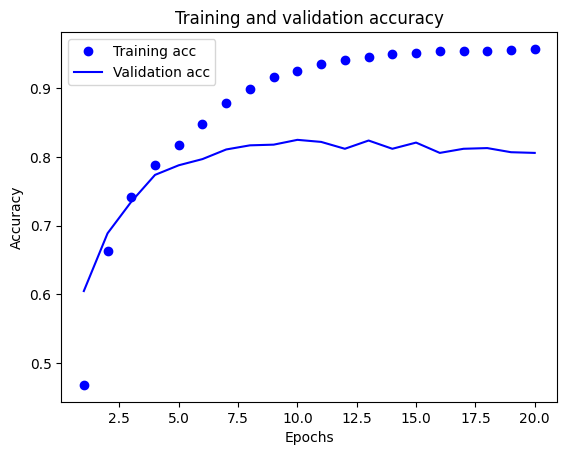

In [20]:
plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

이 모델은 아홉 번째 에포크 이후에 과대적합이 시작됩니다. 아홉 번의 에포크로 새로운 모델을 훈련하고 테스트 세트에서 평가하겠습니다.
#### 코드 3-21 모델을 처음부터 다시 훈련하기

In [22]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=9,
                    batch_size=512,
                    validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)
results

Epoch 1/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3813 - loss: 3.2394 - val_accuracy: 0.6050 - val_loss: 1.8895
Epoch 2/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6388 - loss: 1.7028 - val_accuracy: 0.6800 - val_loss: 1.3961
Epoch 3/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7290 - loss: 1.2345 - val_accuracy: 0.7350 - val_loss: 1.1952
Epoch 4/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7940 - loss: 0.9732 - val_accuracy: 0.7650 - val_loss: 1.0861
Epoch 5/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8185 - loss: 0.8381 - val_accuracy: 0.7910 - val_loss: 1.0151
Epoch 6/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8464 - loss: 0.7230 - val_accuracy: 0.8030 - val_loss: 0.9678
Epoch 7/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8803 - loss: 0.5713 - val_accuracy: 0.7970 - val_loss: 0.9679
Epoch 8/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8977 - loss: 0.5009 - val_accuracy: 0.8100 - val_loss:

[0.9430945515632629, 0.7818343639373779]

대략 78%의 정확도를 달성했습니다. 균형 잡힌 이진 분류 문제에서 완전히 무작위로 분류하면 50%의 정확도를 달성합니다. 이 문제는 불균형한 데이터셋을 사용하므로 무작위로 분류하면 18% 정도를 달성합니다. 여기에 비하면 이 결과는 꽤 좋은 편입니다.

In [24]:
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
hits_array = np.array(test_labels) == np.array(test_labels_copy)
float(np.sum(hits_array)) / len(test_labels)

0.19100623330365094

### 3.5.5 새로운 데이터에 대해 예측하기
#### 코드 3-22 새로운 데이터에 대해 예측하기

In [25]:
predictions = model.predict(x_test)

predictions[0].shape

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


(46,)

In [26]:
np.sum(predictions[0])

1.0

In [27]:
np.argmax(predictions[0])

3

### 3.5.6 레이블과 손실을 다루는 다른 방법
레이블을 인코딩하는 다른 방법은 다음과 같이 정수 텐서로 변환하는 것입니다.

In [28]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

이 방식을 사용하려면 손실 함수 하나만 바꾸면 됩니다. 정수 레이블을 사용할때는 sparse_categorical_crossentropy를 사용해야 합니다.

In [29]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### 3.5.7 충분히 큰 중간층을 두어야 하는 이유
앞서 언급한 것처럼 마지막 출력이 46차원이기 때문에 중간층의 히든 유닛이 46개보다 많이 적어서는 안 됩니다. 46차원보다 훨씬 작은 중간층(예를 들어 4차원)을 두면 정보의 병목이 어떻게 나타나는지 확인해 보겠습니다.
#### 코드 3-23 정보 병목이 있는 모델

In [31]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1383 - loss: 3.6180 - val_accuracy: 0.3340 - val_loss: 3.1889
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3387 - loss: 3.0640 - val_accuracy: 0.3700 - val_loss: 2.7610
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3895 - loss: 2.6199 - val_accuracy: 0.4020 - val_loss: 2.3427
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4218 - loss: 2.1962 - val_accuracy: 0.4150 - val_loss: 2.0188
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4725 - loss: 1.9432 - val_accuracy: 0.5810 - val_loss: 1.8056
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5969 - loss: 1.6819 - val_accuracy: 0.5830 - val_loss: 1.6652
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5906 - loss: 1.5565 - val_accuracy: 0.6100 - val_loss: 1.5620
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6219 - loss: 1.4529 - val_accuracy: 0.6290 - v

검증 정확도의 최고 값은 약 71%로 8% 정도 감소 되었습니다. 이런 손실의 원인 대부분은 많은 정보(클래스 46개의 분할 초평면을 복원하기에 충분한 정보)를 중간층의 저차원 표현 공간으로 압축하려고 했기 때문입니다.
### 3.5.8 추가 실험
- 더 크거나 작은 층을 사용해 보세요. 32개의 유닛, 128개의 유닛 등
- 여기에서 2개의 은닉 층을 사용했습니다. 1개나 3개의 은닉 층을 사용해 보세요.

In [32]:
# 32개 유닛 사용
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2105 - loss: 3.5723 - val_accuracy: 0.4680 - val_loss: 2.6477
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5452 - loss: 2.3503 - val_accuracy: 0.6420 - val_loss: 1.8717
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6786 - loss: 1.6726 - val_accuracy: 0.6790 - val_loss: 1.5278
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7126 - loss: 1.3642 - val_accuracy: 0.7040 - val_loss: 1.3467
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7467 - loss: 1.1728 - val_accuracy: 0.7250 - val_loss: 1.2434
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7768 - loss: 1.0405 - val_accuracy: 0.7410 - val_loss: 1.1471
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8017 - loss: 0.9085 - val_accuracy: 0.7530 - val_loss: 1.0963
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8253 - loss: 0.8001 - val_accuracy: 0.7720 - val_loss

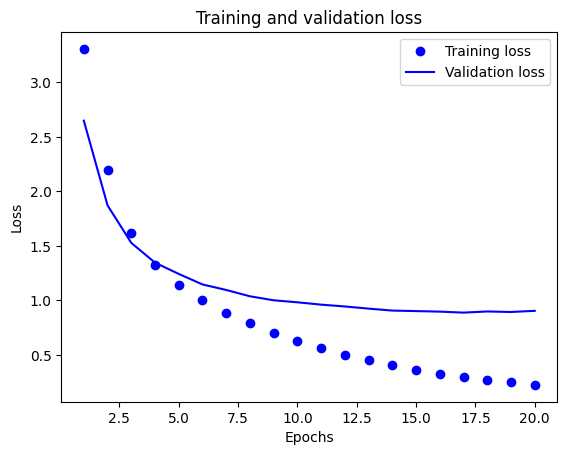

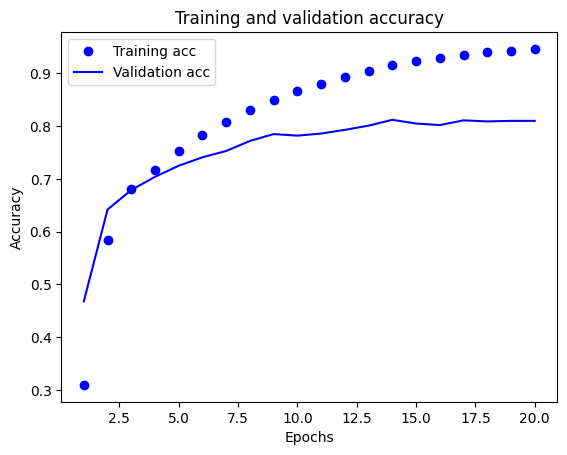

In [33]:
plt.clf()

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

→ training, val 의 loss, acc 가 천천히 saturation 된다. 숫자가 비슷한 걸로 봐서는 굳이 천천히 saturation 되지 않고 바로 되도록 64개 유닛 쓰는게 나은것 같다.

In [34]:
# 128개 유닛 사용
model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4384 - loss: 2.8939 - val_accuracy: 0.6590 - val_loss: 1.5066
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6990 - loss: 1.3532 - val_accuracy: 0.7350 - val_loss: 1.2081
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7849 - loss: 1.0021 - val_accuracy: 0.7610 - val_loss: 1.0526
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8210 - loss: 0.8040 - val_accuracy: 0.7900 - val_loss: 0.9763
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8681 - loss: 0.6256 - val_accuracy: 0.7810 - val_loss: 0.9859
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8908 - loss: 0.4950 - val_accuracy: 0.8220 - val_loss: 0.8590
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9180 - loss: 0.3789 - val_accuracy: 0.8150 - val_loss: 0.8657
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9355 - loss: 0.3028 - val_accuracy: 0.8130 - v

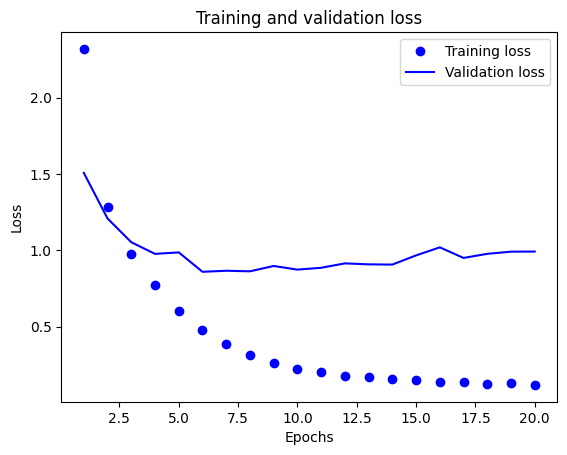

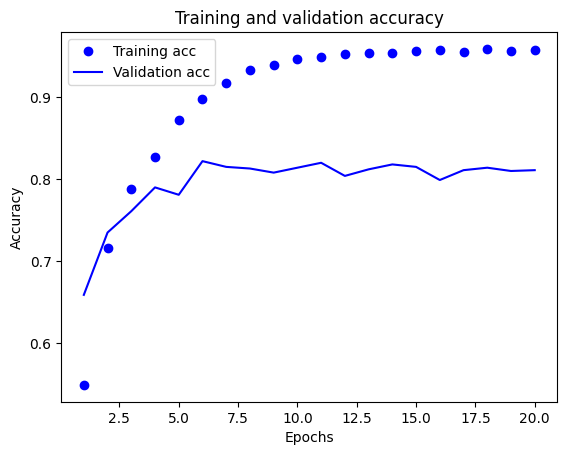

In [35]:
plt.clf()

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

→ 6 에포크 만에 최고 정확도 도달해서 과적합된다. 유닛 128개 사용하니 빠르게 도달한다.
### 3.5.9 정리
- N개의 클래스로 데이터 포인트를 분류하려면 네트워크의 마지막 Dense 층의 크기는 N이어야 합니다.
- 단일 레이블, 다중 분류 문제에서는 N개의 클래스에 대한 확률 분포를 출력하기 위해 softmax 활성화 함수를 사용해야 합니다.
- 이런 문제에는 항상 범주형 크로스엔트로피를 사용해야 합니다. 이 함수는 모델이 출력한 확률 분포와 타깃 분포 사이의 거리를 최소화합니다.
- 다중 분류에서 레이블을 다루는 두 가지 방법이 있습니다.
  - 레이블을 범주형 인코딩(또는 원-핫 인코딩)으로 인코딩 하고 categorical_crossentropy 손실 함수를 사용합니다.
  - 레이블을 정수로 인코딩하고 sparse_categorical_crossentropy 손실함수를 사용합니다.
- 많은 수의 범주를 분류할 때 중간층의 크기가 너무 작아 네트워크에 정보의 병목이 생기지 않도록 해야 합니다.